# Imports Table

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV


from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression



In [2]:

schools_raw = pd.read_csv('schools_data_BACKUP.csv')

In [3]:
schools_raw.head(2)

,id,name,type,level,level_codes,city,state,zip_code,district,latitude,longitude,rating,rating_year,distance
0,3605242,The Karafin School,private,"9,10,11,12",h,Mount Kisco,NY,10549,NaN,41.204262,-73.727074,NaN,NaN,0.34826
1,3607320,Talmud Torah Bais Yechiel-Nitra,private,"PK,KG,1,2,3,4,5,6,7,8,9","p,e,m",Mount Kisco,NY,11211,NaN,41.204262,-73.727074,NaN,NaN,0.34826


In [4]:

demog_raw = pd.read_csv('demographics_mstr_BACKUP.csv')

In [5]:
demog_raw.head(2)

,enrollment,percent-reduced-lunch,percent-disadvantaged,percent-limited-english,average-salary,student-teacher-ratio,student-counselor-ratio,percentage-female,teachers-experience,percentage-certified,Universal_ID,Hispanic,White,African American,Asian,Native Hawaiian or Other Pacific Islander,Two or more races,Native American,Asian or Pacific Islander
0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,44.4444,NaN,NaN,3605242,43.0556,34.7222,19.4444,2.77778,0.0,0.0,0.0,NaN
1,231.0,NaN,NaN,NaN,NaN,NaN,NaN,40.2597,NaN,NaN,3607320,0.0000,100.0000,0.0000,0.00000,0.0,0.0,0.0,NaN


In [6]:
# merge right on 'id', left on 'Universal_ID'

df = schools_raw.merge(demog_raw, left_on='id', right_on='Universal_ID', how='outer')

In [7]:
# inspect merge results

df.head()

,id,name,type,level,level_codes,city,state,zip_code,district,latitude,...,percentage-certified,Universal_ID,Hispanic,White,African American,Asian,Native Hawaiian or Other Pacific Islander,Two or more races,Native American,Asian or Pacific Islander
0,3605242,The Karafin School,private,"9,10,11,12",h,Mount Kisco,NY,10549,NaN,41.204262,...,NaN,3605242.0,43.055600,34.722200,19.444400,2.77778,0.0,0.000000,0.000000,NaN
1,3607320,Talmud Torah Bais Yechiel-Nitra,private,"PK,KG,1,2,3,4,5,6,7,8,9","p,e,m",Mount Kisco,NY,11211,NaN,41.204262,...,NaN,3607320.0,0.000000,100.000000,0.000000,0.00000,0.0,0.000000,0.000000,NaN
2,3601714,Mount Kisco Elementary School,public,"KG,1,2,3,4,5",e,Mount Kisco,NY,10549,Bedford Central School District,41.202629,...,100.0,3601714.0,66.276803,25.146198,2.534113,NaN,0.0,3.313840,0.000000,2.729044
3,3601716,West Patent Elementary School,public,"KG,1,2,3,4,5,UG",e,Bedford Hills,NY,10507,Bedford Central School District,41.214245,...,100.0,3601716.0,31.023102,54.785478,2.640264,NaN,0.0,4.620462,0.330033,6.600660
4,3615676,The Country Childrens Center,private,"PK,KG","p,e",Bedford Hills,NY,10507,NaN,41.234066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# look for big patterns

df.describe()

,id,zip_code,latitude,longitude,rating,rating_year,distance,enrollment,percent-reduced-lunch,percent-disadvantaged,...,percentage-certified,Universal_ID,Hispanic,White,African American,Asian,Native Hawaiian or Other Pacific Islander,Two or more races,Native American,Asian or Pacific Islander
count,2.439000e+03,2439.000000,2439.000000,2439.000000,1358.000000,1358.000000,2439.000000,1597.000000,1236.000000,0.0,...,1207.000000,1.598000e+03,1598.000000,1597.000000,1589.000000,336.000000,1492.000000,1577.000000,1472.000000,1256.000000
mean,3.121916e+06,9471.830668,41.014540,-73.822946,5.698085,2020.159057,22.675495,491.680651,53.025119,NaN,...,97.229572,3.558905e+06,37.447865,34.984417,16.978432,8.620144,0.306179,2.377534,0.419495,7.474823
std,9.911636e+05,1762.954291,0.195947,0.248301,2.392295,0.365864,6.135103,381.706007,35.478441,NaN,...,10.157801,8.596574e+04,28.045081,33.319836,19.935998,16.762758,0.981407,4.424197,1.048054,10.330613
min,9.000030e+05,6468.000000,40.771336,-74.294998,1.000000,2020.000000,0.348260,0.000000,0.000000,NaN,...,11.111111,3.400031e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.402210e+06,7605.000000,40.854503,-73.978736,4.000000,2020.000000,19.161671,272.000000,15.147420,NaN,...,100.000000,3.600484e+06,11.074229,2.191200,2.000000,0.000000,0.000000,0.218340,0.000000,1.183901
50%,3.602566e+06,10457.000000,40.943081,-73.890633,6.000000,2020.000000,24.818930,422.000000,60.674377,NaN,...,100.000000,3.603172e+06,32.363706,25.000000,8.890000,2.820789,0.000000,1.049618,0.146960,3.517653
75%,3.607492e+06,10583.000000,41.131378,-73.730396,8.000000,2020.000000,27.360833,605.000000,87.421413,NaN,...,100.000000,3.607202e+06,62.782643,66.666651,25.714300,9.143765,0.312014,3.183023,0.518487,8.916137
max,3.618423e+06,12590.000000,41.606472,-73.145691,10.000000,2021.000000,29.999681,4845.000000,100.000000,NaN,...,100.000000,3.618421e+06,100.000000,100.000000,100.000000,100.000000,20.161300,100.000000,29.951690,67.857142


Text(0.5, 1.0, 'Distribution of School Ratings')

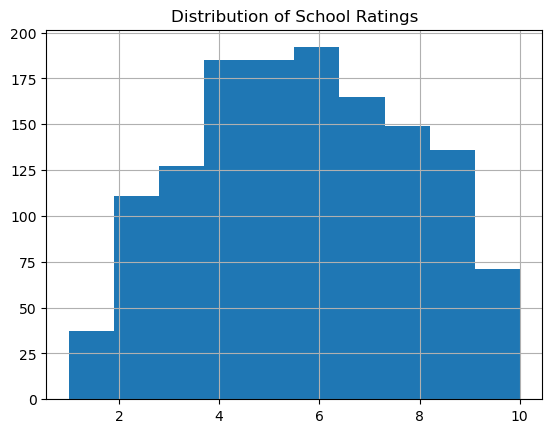

In [9]:


df['rating'].hist()
plt.title('Distribution of School Ratings')

In [10]:
# check for duplicates in main identifier

df[df.duplicated(subset='id', keep=False)]

,id,name,type,level,level_codes,city,state,zip_code,district,latitude,...,percentage-certified,Universal_ID,Hispanic,White,African American,Asian,Native Hawaiian or Other Pacific Islander,Two or more races,Native American,Asian or Pacific Islander


In [11]:


df['district'].value_counts()

New York City Geographic District #10                 85
New York City Geographic District # 9                 69
New York City Geographic District #11                 62
New York City Geographic District # 8                 56
New York City Geographic District #12                 50
                                                      ..
Grand Concourse Academy Charter School                 1
Bronx Preparatory Charter School                       1
Urban Assembly Charter School for Computer Science     1
Icahn Charter School 1                                 1
New York City Geographic District #26                  1
Name: district, Length: 302, dtype: int64

In [12]:
# ratings by district

(
    df.groupby(by='district')['rating']
    .agg(mean='mean').sort_values(by='mean', ascending=False).head(50)
)


,mean
district,
Academic Leadership Charter School,10.000000
Oradell Public School District,10.000000
Englewood Cliffs School District,10.000000
Icahn Charter School 3,10.000000
Bronx Charter School for Excellence 2,10.000000
Allendale Public School District,10.000000
New York City Geographic District #26,10.000000
Success Academy Charter School-Bronx 2,10.000000
Northern Valley Regional High School District,10.000000


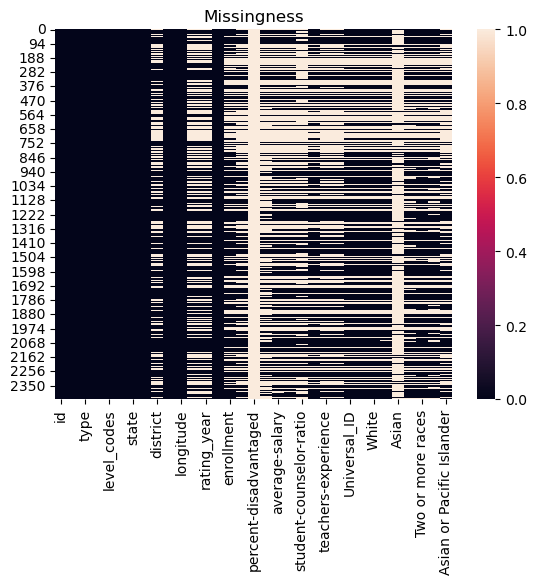

In [13]:
# missingness

sns.heatmap(df.isnull())
plt.title('Missingness')
plt.show()

In [14]:
# percent null

round(df.isnull().sum()/len(df),2)*100

id                                             0.0
name                                           0.0
type                                           0.0
level                                          0.0
level_codes                                    0.0
city                                           0.0
state                                          0.0
zip_code                                       0.0
district                                      39.0
latitude                                       0.0
longitude                                      0.0
rating                                        44.0
rating_year                                   44.0
distance                                       0.0
enrollment                                    35.0
percent-reduced-lunch                         49.0
percent-disadvantaged                        100.0
percent-limited-english                       61.0
average-salary                                51.0
student-teacher-ratio          

In [15]:
# drop 100% null column

df = df.drop(columns=['percent-disadvantaged'])

In [16]:
# cross join on district to fill average salary?

unique_salary = (
    df.groupby(by='district')['average-salary']
    .agg(nunique='nunique').sort_values(by='nunique')['nunique'].eq(1)
)

unique_salary

district
Abbott Union Free School District                                False
New York State Office Mental Health (Office of Mental Health)    False
New Milford School District                                      False
New Fairfield School District                                    False
New Canaan School District                                       False
                                                                 ...  
New York City Geographic District #12                            False
New York City Geographic District # 8                            False
New York City Geographic District #11                            False
New York City Geographic District # 9                            False
New York City Geographic District #10                            False
Name: nunique, Length: 302, dtype: bool

In [17]:
#inspect salaries per district
df.dropna(subset='district').set_index(['district','average-salary']).head()

id  \
district                          average-salary            
Bedford Central School District   102982.15       3601714   
                                  122886.80       3601716   
                                  109263.82       3601711   
Chappaqua Central School District 100143.00       3607765   
                                  117754.02       3600514   

                                                                             name  \
district                          average-salary                                    
Bedford Central School District   102982.15         Mount Kisco Elementary School   
                                  122886.80         West Patent Elementary School   
                                  109263.82       Bedford Hills Elementary School   
Chappaqua Central School District 100143.00           Seven Bridges Middle School   
                                  117754.02            Horace Greeley High School   

                                                    type            level  \
district                          average-salary                            
Bedford Central School District   102982.15       public     KG,1,2,3,4,5   
                                  122886.80       public  KG,1,2,3,4,5,UG   
                                  109263.82       public  KG,1,2,3,4,5,UG   
Chappaqua Central School District 100143.00       public          5,6,7,8   
                                  117754.02       public    9,10,11,12,UG   

                                                 level_codes           city  \
district                          average-salary                              
Bedford Central School District   102982.15                e    Mount Kisco   
                                  122886.80                e  Bedford Hills   
                                  109263.82                e  Bedford Hills   
Chappaqua Central School District 100143.00              e,m      CHAPPAQUA   
                                  117754.02                h      Chappaqua   

                                                 state  zip_code   latitude  \
district                          average-salary                              
Bedford Central School District   102982.15         NY     10549  41.202629   
                                  122886.80         NY     10507  41.214245   
                                  109263.82         NY     10507  41.236546   
Chappaqua Central School District 100143.00         NY     10514  41.207047   
                                  117754.02         NY     10514  41.174381   

                                                  longitude  ...  \
district                          average-salary             ...   
Bedford Central School District   102982.15      -73.728523  ...   
                                  122886.80      -73.702850  ...   
                                  109263.82      -73.693375  ...   
Chappaqua Central School District 100143.00      -73.772240  ...   
                                  117754.02      -73.755005  ...   

                                                  percentage-certified  \
district                          average-salary                         
Bedford Central School District   102982.15                      100.0   
                                  122886.80                      100.0   
                                  109263.82                      100.0   
Chappaqua Central School District 100143.00                      100.0   
                                  117754.02                      100.0   

                                                  Universal_ID   Hispanic  \
district                          average-salary                            
Bedford Central School District   102982.15          3601714.0  66.276803   
                                  122886.80          3601716.0  31.023102   
                                  109263.82          3601711.0  50.704225   
Ch

In [18]:
# observe asian and 'Asian or Pacific Islander'

df[['Asian', 'Asian or Pacific Islander']] # appears to be an or-condition

bad_overlap = (df['Asian'].notna() & df['Asian or Pacific Islander'].notna())

assert not bad_overlap.any(), 'Columns not mergable'

In [19]:
# merge asian and asian or pacific islander

df['Asian_combo'] = (
    df['Asian'].fillna(df['Asian or Pacific Islander'])
)

# drop original cols

df = df.drop(columns=['Asian', 'Asian or Pacific Islander'])


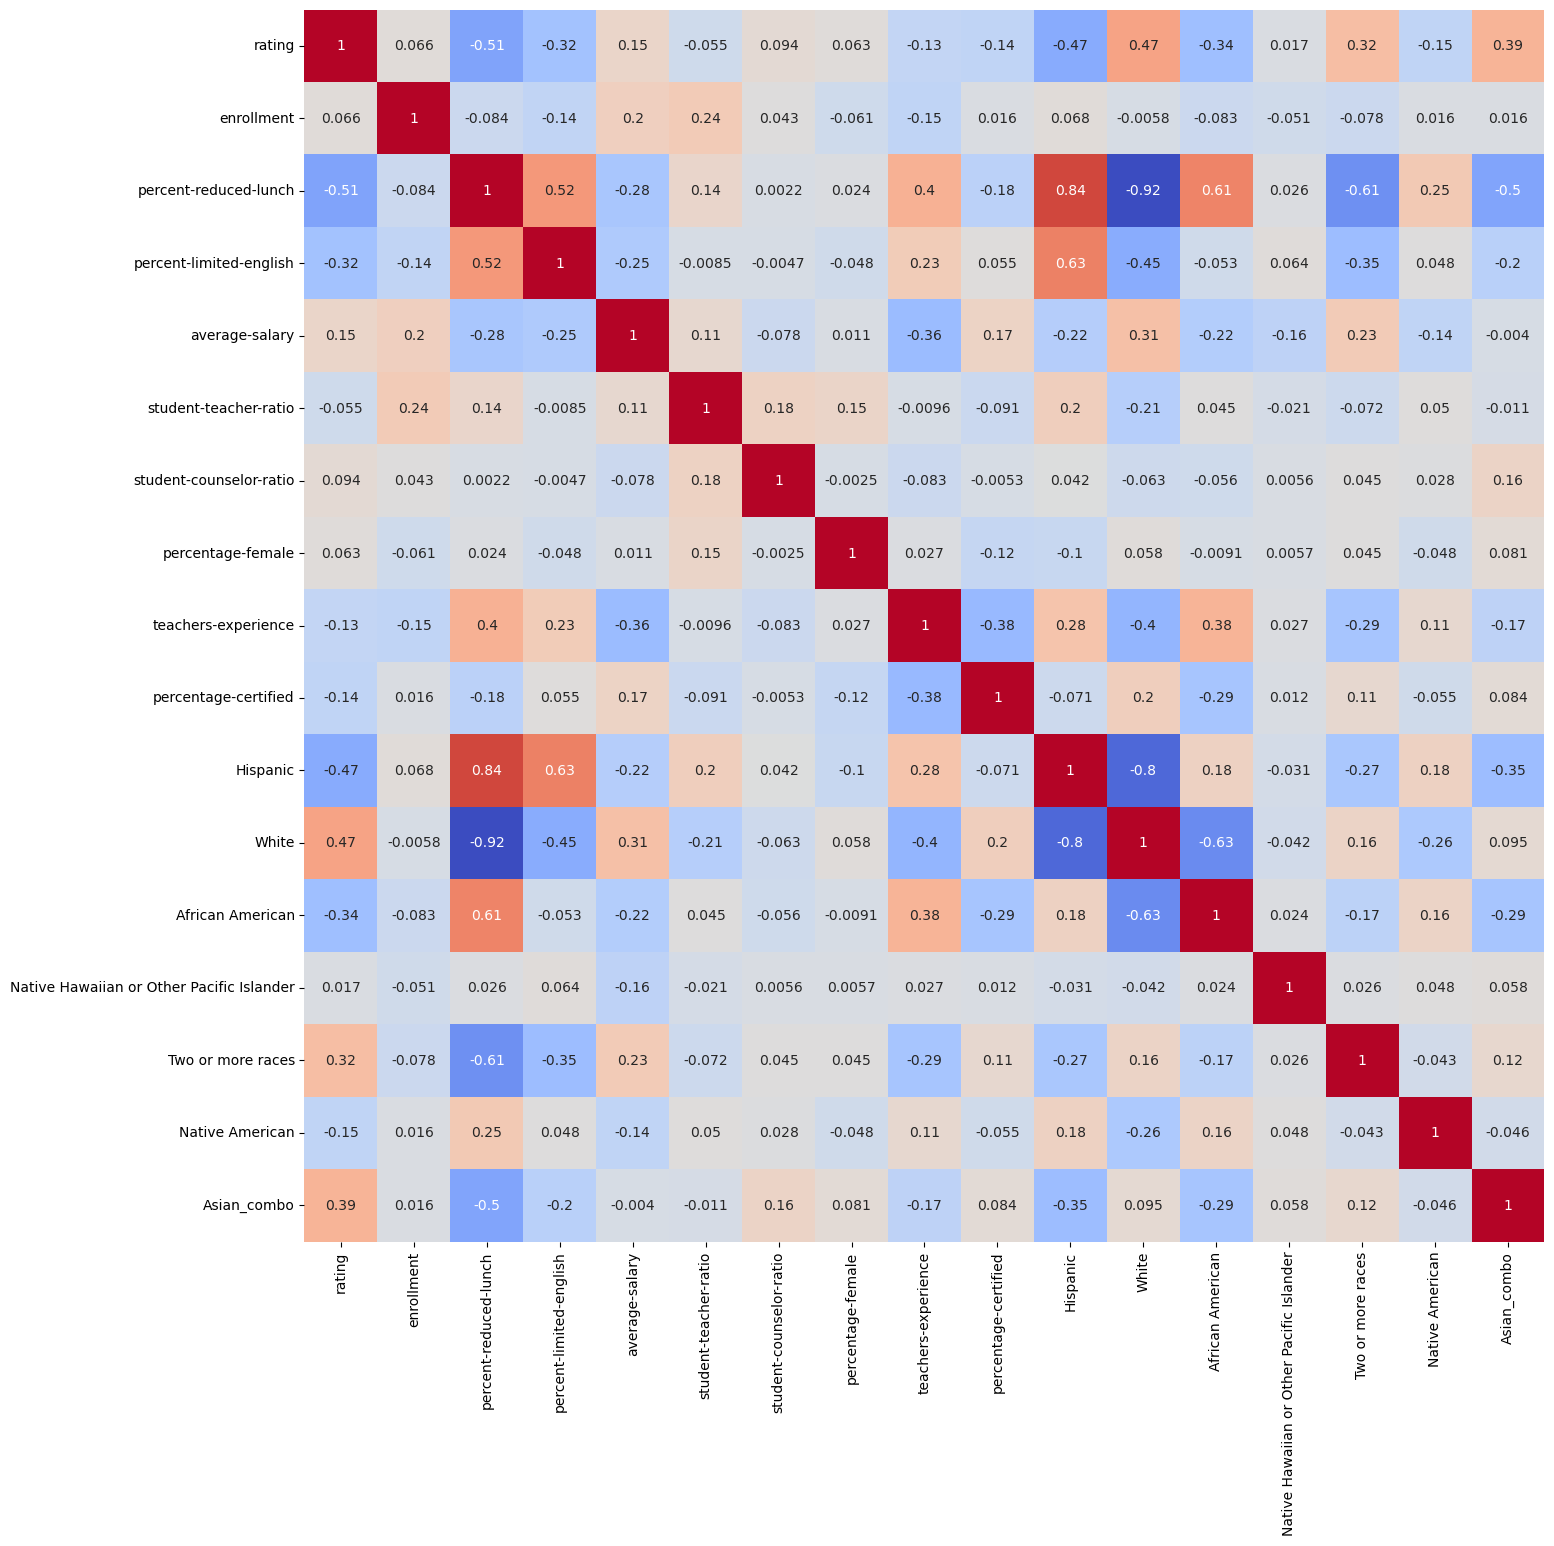

In [20]:
# inspect feature correlations with heatmap

fig, ax = plt.subplots(figsize=(16,16))
corr = df.drop(
    columns=['Universal_ID','id','zip_code','distance', 'rating_year','latitude', 'longitude']
).select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cbar=False, cmap='coolwarm')
plt.show()

In [21]:
# drop data with no rating

df_rating = df.dropna(subset='rating').copy()

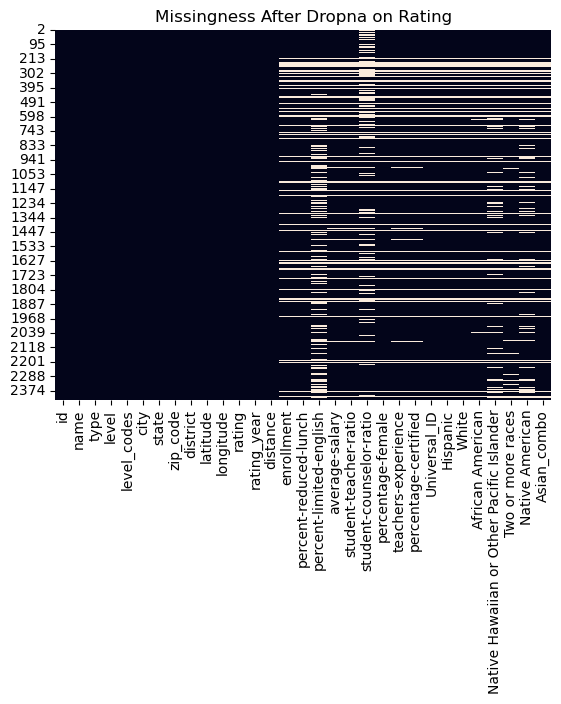

In [22]:
# check missingness after dropping blank ratings

sns.heatmap(df_rating.isna(), cbar=False)
plt.title('Missingness After Dropna on Rating')
plt.show()

In [23]:
#observe remaining missingness

(df_rating.isnull().sum()/len(df_rating)).sort_values(ascending=False)

student-counselor-ratio                      0.339470
percent-limited-english                      0.337261
Native American                              0.242268
Native Hawaiian or Other Pacific Islander    0.223859
Two or more races                            0.171576
percentage-certified                         0.168630
teachers-experience                          0.168630
student-teacher-ratio                        0.168630
average-salary                               0.168630
African American                             0.164212
Asian_combo                                  0.159794
White                                        0.158321
Hispanic                                     0.158321
Universal_ID                                 0.158321
percentage-female                            0.158321
percent-reduced-lunch                        0.158321
enrollment                                   0.158321
name                                         0.000000
distance                    

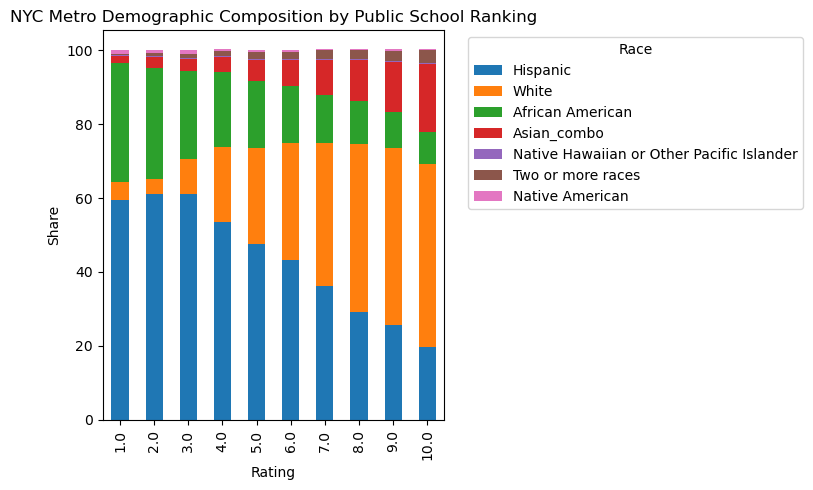

In [24]:
# stacked bar chart



demog_race = ['Hispanic', 'White','African American', 'Asian_combo', 
              'Native Hawaiian or Other Pacific Islander', 'Two or more races',
              'Native American']

plot_df = (
    df_rating
    .groupby('rating')[demog_race]
    .mean()     # or .sum(), depending on meaning
    .sort_index()
)

ax = plot_df.plot(kind='bar', stacked=True, figsize=(8, 5))
ax.set_ylabel('Share')
ax.set_xlabel('Rating')
ax.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("NYC Metro Demographic Composition by Public School Ranking")
plt.tight_layout()


In [25]:
# reducted lunch by demography

mask_105 = df_rating['zip_code'].astype('str').str.startswith('105')

print(f"Number of observations under a 105xx area code: {len(df_rating[mask_105])}")

df_rating.loc[mask_105, 'zip_code'].astype('str').str[-2:].nunique()

Number of observations under a 105xx area code: 160


49

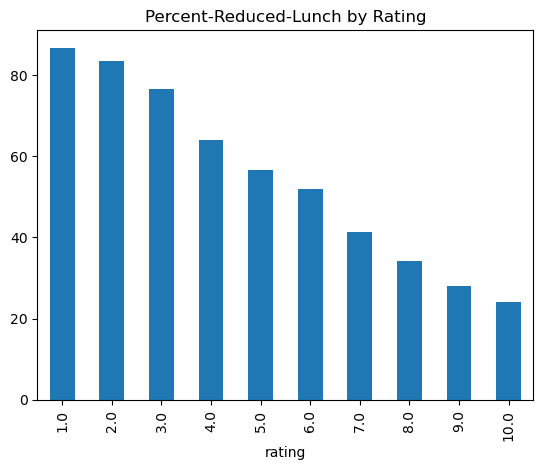

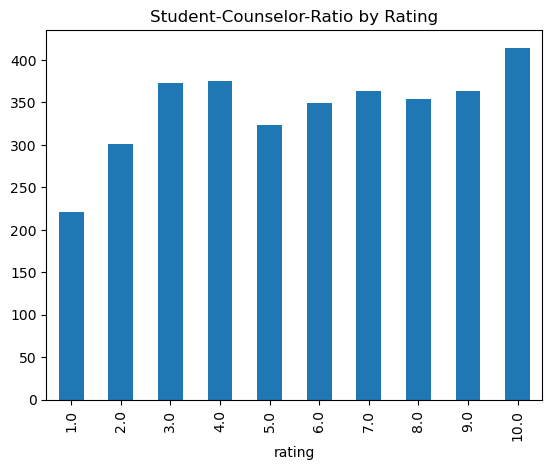

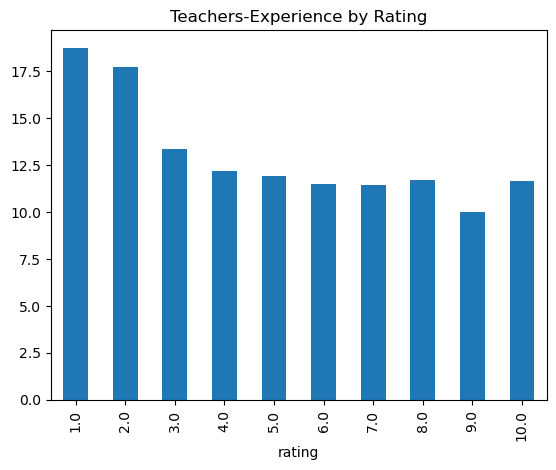

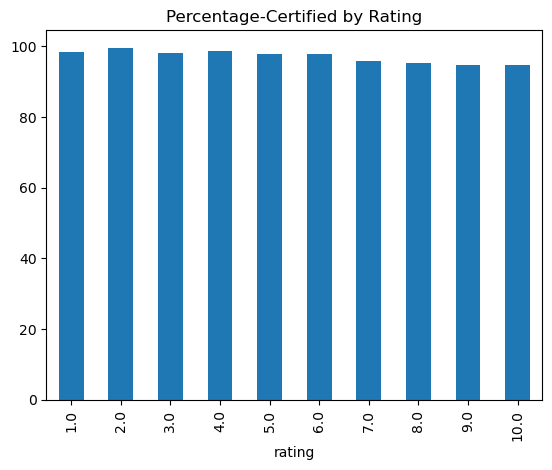

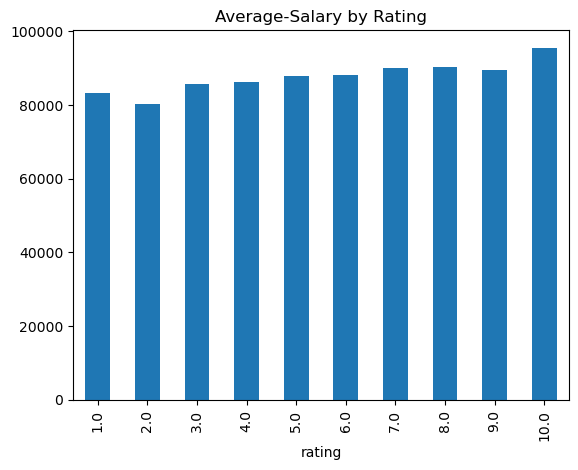

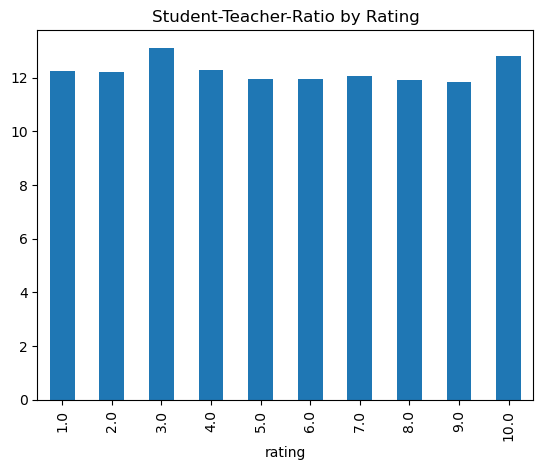

In [26]:
# model funding-related features


bar_cols = ['percent-reduced-lunch', 
'student-counselor-ratio', 
'teachers-experience', 
'percentage-certified', 
'average-salary',
           'student-teacher-ratio']

for col in bar_cols:
    plot_table = (df_rating.groupby('rating')[col]
    .agg(col='mean')
    .sort_index())
    
    plot_table.plot(kind='bar', legend=False)
    plt.title(f'{col.title()} by Rating')
    plt.show()

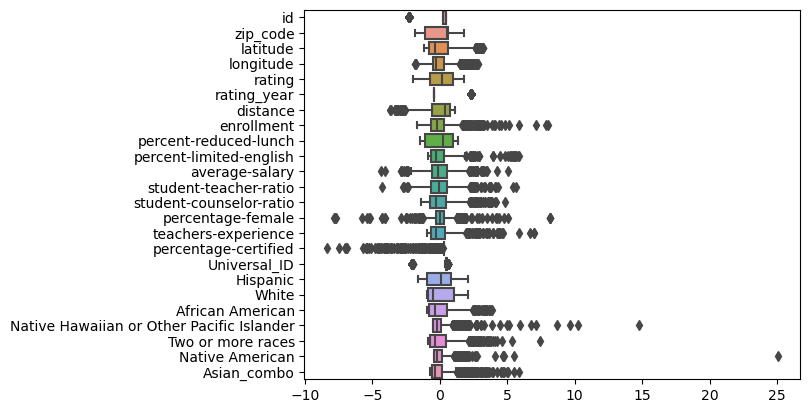

In [27]:
# check_for_outliers

scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_rating.select_dtypes(include=['number']).copy())
df_scaled = pd.DataFrame(scaled_array,
                        columns=df_rating.select_dtypes(include=['number']).columns, index=df_rating.index)

df_scaled
sns.boxplot(df_scaled, orient='h')
plt.show()



In [28]:
# define simplex cols

simplex_cols = ['Hispanic', 'White',
       'African American', 'Native Hawaiian or Other Pacific Islander',
       'Two or more races', 'Native American', 'Asian_combo']


In [29]:
# verify simplex columns

#assert np.isclose(df_rating[simplex_cols].sum(axis=1), 100).all(), "Simplexes not mathing"

In [30]:
#check if any cols add to 100

assert np.isclose(df_rating[simplex_cols].sum(axis=1), 100).any(), "Simplexes not mathing"

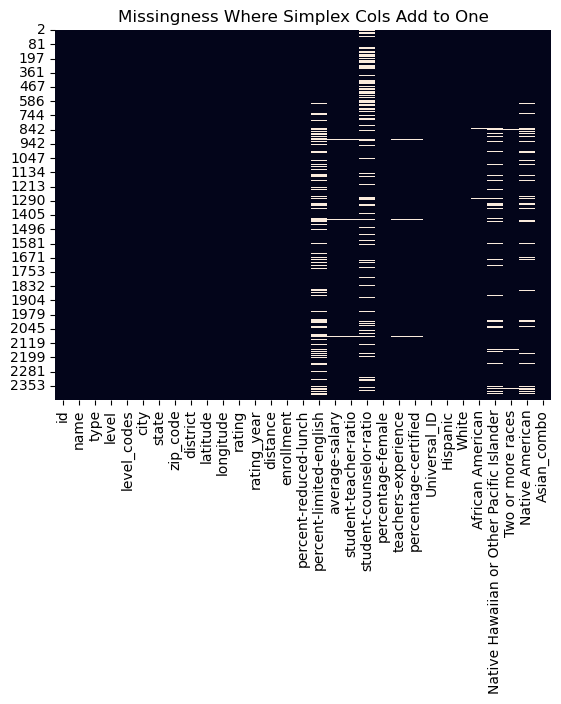

In [31]:
# rows where simplex columns are working

sns.heatmap(df_rating[np.isclose(df_rating[simplex_cols].sum(axis=1), 100, atol=0.01)].isna(), cbar=False)
plt.title('Missingness Where Simplex Cols Add to One')
plt.show()

In [32]:
# observe rows where simplexes do not add up

df_rating[~np.isclose(df_rating[['Hispanic', 'White',
       'African American', 'Native Hawaiian or Other Pacific Islander',
       'Two or more races', 'Native American', 'Asian_combo']].sum(axis=1), 100, atol=0.01)]['state'].value_counts()

# all rows are in the state of Connecticut, which maybe does not publish demographic data

CT    215
Name: state, dtype: int64

In [33]:
# drop rows where state is connecticut
# connecticut data could be useful in some other context

ct_rows = df_rating[df_rating['state']=='CT'].index

df_rating = df_rating.drop(ct_rows)

In [34]:
# verify that simplex columns now add all to one with Connecticut dropped
assert np.isclose(df_rating[['Hispanic', 'White',
       'African American', 'Native Hawaiian or Other Pacific Islander',
       'Two or more races', 'Native American', 'Asian_combo']].sum(axis=1), 100).all(), "Simplexes not mathing"

In [35]:
# fill null values in add-to-one columns with zeros

df_rating[simplex_cols] = df_rating[simplex_cols].fillna(0.0)

In [36]:
df_rating.columns

Index(['id', 'name', 'type', 'level', 'level_codes', 'city', 'state',
       'zip_code', 'district', 'latitude', 'longitude', 'rating',
       'rating_year', 'distance', 'enrollment', 'percent-reduced-lunch',
       'percent-limited-english', 'average-salary', 'student-teacher-ratio',
       'student-counselor-ratio', 'percentage-female', 'teachers-experience',
       'percentage-certified', 'Universal_ID', 'Hispanic', 'White',
       'African American', 'Native Hawaiian or Other Pacific Islander',
       'Two or more races', 'Native American', 'Asian_combo'],
      dtype='object')

# Preprocessing

With pipeline

In [37]:
# construct a binary target
mean_rating = df_rating['rating'].mean()

df_rating['above_average'] = np.where(df_rating['rating']>mean_rating, 1, 0)

In [38]:
# condense zip codes into smaller categories

df_rating['zip_4'] = df_rating['zip_code'].astype('str').str[0:4]

In [71]:
# create ILR transformer
class ILRTransformer(BaseEstimator, TransformerMixin):
    """
    Apply ILR transform to a set of compositional columns.
    X is expected to be a DataFrame when used standalone;
    inside ColumnTransformer it will be a NumPy array with only `cols`.
    """
    def __init__(self, cols, prefix="ilr"):
        self.cols = cols
        self.prefix = prefix
        self.V_ = None   # ILR basis (D-1 x D)
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        D = len(self.cols)
        # Build a Helmert-like matrix to get an orthonormal basis
        H = np.zeros((D, D))
        for i in range(1, D):
            H[i, :i] = 1.0 / i
            H[i, i] = -1.0
        # QR on the (D x (D-1)) submatrix to get orthonormal columns
        Q, _ = np.linalg.qr(H[:, 1:])
        self.V_ = Q.T      # shape: (D-1, D)

        # tell sklearn how many features we output and what they’re called
        n_out = D - 1
        self.feature_names_out_ = np.array(
            [f"{self.prefix}_{j}" for j in range(n_out)],
            dtype=object
        )
        return self

    def transform(self, X):
        # handle both DataFrame and ndarray (inside ColumnTransformer)
        if isinstance(X, pd.DataFrame):
            Xs = X[self.cols].to_numpy(dtype=float)
        else:
            Xs = np.asarray(X, dtype=float)

        # Avoid log(0)
        Xs = np.clip(Xs, 1e-12, None)
        logX = np.log(Xs)
        clr = logX - logX.mean(axis=1, keepdims=True)  # n x D
        # ILR coords: n x (D-1)
        Z = clr @ self.V_.T
        return Z

    def get_feature_names_out(self, input_features=None):
        # ColumnTransformer will pass in the original feature names subset;
        # we just ignore and return our ILR coord names.
        return self.feature_names_out_


In [74]:
# pipeline

# define the columns
simplex_cols = simplex_cols

num_cols     = ['distance', 'enrollment', 'percent-reduced-lunch',
       'percent-limited-english', 'average-salary', 'student-teacher-ratio',
       'student-counselor-ratio', 'percentage-female', 'teachers-experience',
       'percentage-certified']   

cat_cols     = ["zip_4", 'state']   # or "zip3" or whatever you decided


# numeric pipeline: impute + scale
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("scale", StandardScaler()),
])

# simplex / race pipeline: impute + ILR
ilr_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ilr", ILRTransformer(simplex_cols)),
])


preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("ilr", ilr_pipe, simplex_cols),
    ],
    remainder="drop",
)

logit_pipe = Pipeline([
    ("preprocess", preprocess),
    ("logit", LogisticRegression(max_iter=2000))
])

tree_pipe = Pipeline([
    ("preprocess", preprocess),
    ('tree', DecisionTreeClassifier(random_state=21))
])


In [75]:
# decision tree model

X = df_rating[simplex_cols + cat_cols + num_cols]
y = df_rating['above_average']


param_grid = {
    "tree__max_depth": [None, 3, 5, 10],
    "tree__min_samples_leaf": [1, 5, 10],
    "tree__min_samples_split": [2, 5, 10],
}

grid = GridSearchCV(
    tree_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
)

grid.fit(X, y)

grid.best_params_, grid.best_score_

({'tree__max_depth': 5,
  'tree__min_samples_leaf': 10,
  'tree__min_samples_split': 2},
 0.7323598194535383)

In [78]:
# pipeline

X = df_rating[simplex_cols + cat_cols + num_cols]
y = df_rating['above_average']

for name, pipe in [("logit", logit_pipe), ("tree", tree_pipe)]:
    scores = cross_val_score(
        pipe,
        X_test,
        y_test,
        cv=5,
        scoring="accuracy"   # or "accuracy", etc.
    )

print(scores)
print(f"{name} Mean AUC:", scores.mean())


[0.66666667 0.56521739 0.66666667 0.70588235 0.58823529]
tree Mean AUC: 0.638533674339301


In [59]:
# get some visibility into this thing

X = df_rating[simplex_cols + cat_cols + num_cols]
y = df_rating['above_average']

logit_pipe.fit(X, y)

ct = logit_pipe.named_steps["preprocess"]

X_trans = ct.transform(X) 

feature_names = ct.get_feature_names_out()
print(feature_names)

['num__distance' 'num__enrollment' 'num__percent-reduced-lunch'
 'num__percent-limited-english' 'num__average-salary'
 'num__student-teacher-ratio' 'num__student-counselor-ratio'
 'num__percentage-female' 'num__teachers-experience'
 'num__percentage-certified'
 'num__missingindicator_percent-limited-english'
 'num__missingindicator_average-salary'
 'num__missingindicator_student-teacher-ratio'
 'num__missingindicator_student-counselor-ratio'
 'num__missingindicator_teachers-experience'
 'num__missingindicator_percentage-certified' 'cat__zip_4_1002'
 'cat__zip_4_1003' 'cat__zip_4_1004' 'cat__zip_4_1045' 'cat__zip_4_1046'
 'cat__zip_4_1047' 'cat__zip_4_1050' 'cat__zip_4_1051' 'cat__zip_4_1052'
 'cat__zip_4_1053' 'cat__zip_4_1054' 'cat__zip_4_1055' 'cat__zip_4_1056'
 'cat__zip_4_1057' 'cat__zip_4_1058' 'cat__zip_4_1059' 'cat__zip_4_1060'
 'cat__zip_4_1070' 'cat__zip_4_1071' 'cat__zip_4_1080' 'cat__zip_4_1090'
 'cat__zip_4_1091' 'cat__zip_4_1092' 'cat__zip_4_1095' 'cat__zip_4_1096'
 'cat__

In [63]:

clf = logit_pipe.named_steps["logit"]

coefs = clf.coef_.ravel()  # (n_features,)
feature_names = ct.get_feature_names_out()

coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .assign(abs_coef=lambda d: d["coef"].abs())
      .sort_values("abs_coef", ascending=False)
)

coef_df

,feature,coef,abs_coef
2,num__percent-reduced-lunch,-1.442133,1.442133
17,cat__zip_4_1003,1.351008,1.351008
43,cat__zip_4_1099,-1.290751,1.290751
73,cat__zip_4_7407,-1.286250,1.286250
18,cat__zip_4_1004,1.175107,1.175107
...,...,...,...
11,num__missingindicator_average-salary,0.005081,0.005081
12,num__missingindicator_student-teacher-ratio,0.005081,0.005081
14,num__missingindicator_teachers-experience,0.005081,0.005081
15,num__missingindicator_percentage-certified,0.005081,0.005081


In [61]:
logit_pipe.named_steps

{'preprocess': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('impute',
                                                   SimpleImputer(add_indicator=True,
                                                                 strategy='median')),
                                                  ('scale', StandardScaler())]),
                                  ['distance', 'enrollment',
                                   'percent-reduced-lunch',
                                   'percent-limited-english', 'average-salary',
                                   'student-teacher-ratio',
                                   'student-counselor-ratio',
                                   'percentage-female', 'teachers-experience',
                                   'percentage-certifi...
                                  Pipeline(steps=[('impute',
                                                   SimpleImputer(strategy='most_frequent')),
                  